# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [ ]:
"""
In this challenge, I only analyze the data from unit0000. I cleaned the data in file unit0000_rms, computing the averge 
value for each of the factors, including the number of alarms, in every 2 days. However, I found that the current, voltage,
motor temperature and inlet temperature are closely correlated. So instead of predicting the unit status with machine 
learning approach, I choose to predict motor statuses by calculating the average current in each of the unit. The higher 
average current corresponds to worse motor status. I think the prediction would be more accurate if I assign each of factors
a weight and optimize them with machine learning approach. But due to the time constraint, calculating the average
currency may be a simpler way for motor failor prediction.
"""
pass

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,4
unique,4
top,warning
freq,1


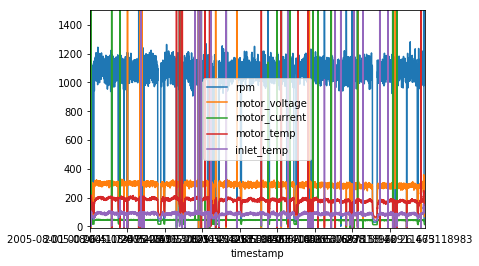

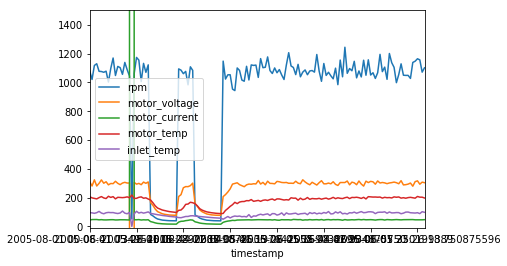

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp").describe()

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

In [2]:
"""
observing the figures generated by rms.describe(), values such as mean of rpm is negative. There must exist abnormal values
in the csv file "unit0000_rms".
Since most values in above tables are not accurate, I choose to clearn data before any analysis.
Observing the datas in file "unit0000_rms", the factor "rpm" range in [0,1200], the voltage ranges in [0,380], current
in [0,100], temp range in [0.300]. I remove abnormal instances with the following abnormal_remove() function.
"""
def abnormal_remove(dataframe):
    date = list(dataframe.index)
    data_values = np.mat(dataframe.values)
    data_columns = dataframe.columns

    for row in range(len(date) - 1, -1, -1):
        flag = 0
        if data_values[row, 0] < 0 or data_values[row, 0] > 1200:
            flag = 1
        if data_values[row, 1] < 0 or data_values[row, 1] > 380:
            flag = 1
        if data_values[row, 2] < 0 or data_values[row, 2] > 100:
            flag = 1
        if data_values[row, 3] < 0 or data_values[row, 3] > 300:
            flag = 1
        if data_values[row, 4] < 0 or data_values[row, 4] > 300:
            flag = 1

        if flag == 1:
            del date[row]
            data_values = np.delete(data_values, (row), axis=0)
    dataframe = pd.DataFrame(data_values, index=date, columns=data_columns)
    return dataframe

In [3]:
"""
I want to collect the the average values associated with factors (rpm, current, voltage, temperature) for every 2 days.
Average values may perform better to prevent noise.
The date_rename() function transform the timestamp in "unit0000_rms" I set the beginning date in unit0000_rms as 10000, 
the second day is 10001, etc. It becomes convenients to decide whether a set of instances are from two successive days.
""" 

def date_rename(dataframe):
    date = list(dataframe.index)
    date_start = pd.to_datetime(date[0][0:10])
    data_values = dataframe.values
    data_columns = dataframe.columns

    length = len(date)
    for indi in range(length):
        today = pd.to_datetime(date[indi][0:10])
        date_diff = (today - date_start).days+10000
        date[indi] = str(date_diff)+date[indi][10:]
        
    dataframe = pd.DataFrame(data_values, index=date, columns = data_columns)
    return dataframe


In [4]:
"""
The following function calculate the average values associated wth each factor in file "unit0000_rms" 
for every 2 days. At the same time, substitute the sampling date with integers ranging in [10000:]. 
"""
def average_tendays(dataframe):
    date = list(dataframe.index)
    data_values = np.mat(dataframe.values)
    data_columns = dataframe.columns

    new_data_values = np.mat(np.zeros((1, len(data_columns))))
    new_date = [date[-1][0:5]]

    date_ini = float(date[-1][0:5])
    temp = np.mat(np.zeros(  (1, len(data_columns))    ))
    for row in range(len(date) - 1, -1, -1):
        if date_ini - float(date[row][0:5]) < 2:
            temp = np.vstack((data_values[row, :], temp))

        else:
            temp = np.delete(temp, (-1), axis=0)
            temp2 = temp.mean(axis=0)
            new_data_values = np.vstack((temp2, new_data_values))

            temp = np.mat(np.zeros((1, len(data_columns))))
            temp = np.vstack((data_values[row, :], temp))
            date_ini = float(date[row][0:5])
            new_date = [date[row][0:5]] + new_date

    temp = np.delete(temp, (-1), axis=0)
    temp2 = temp.mean(axis=0)
    new_data_values = np.vstack((temp2, new_data_values))

    new_data_values = np.delete(new_data_values, (-1), axis=0)
    new_dataframe = pd.DataFrame(new_data_values, index=new_date, columns=data_columns)
    return new_dataframe


In [5]:
rms_modify = abnormal_remove(rms)
rms_date_modi = date_rename(rms_modify)
rms_aver = average_tendays(rms_date_modi)
print(rms_aver)

               rpm  motor_voltage  motor_current  motor_temp  inlet_temp
10001   745.710045     157.227025      21.690476   79.772704   45.915920
10003  1054.298448     223.153150      30.526780  107.912445   61.028951
10005   996.961716     210.973209      29.080334  104.674334   60.086074
10007   674.517644     143.254820      19.725424   77.273489   45.832828
10009  1006.004881     214.163159      29.610348  105.470709   59.914332
10011   912.977375     197.297830      27.237372   99.755406   57.043226
10013   898.916747     195.027335      26.981447   99.649984   56.777814
10015   988.971313     214.835114      30.011344  108.552597   61.193566
10017  1012.727440     221.897408      30.977876  112.487278   62.591233
10019   912.952433     200.815735      28.026605  104.320216   58.948542
10021   764.213862     169.229987      23.521803   91.226565   52.784140
10023  1053.040658     229.242612      31.936975  114.942368   63.000695
10025   998.561217     220.232428      30.736308  1

In [6]:
"""
I also want to figure out how many alarms appears in every 2 days. I suppose the number of alarms is closely related to
the condition of unit.
In next step, I add an empty column to dataframe "rms_aver", then fill the values with data from the file "unit0000_alarm".
"""
def add_zerocolumn(dataframe):
    date = list(dataframe.index)
    data_values = np.mat(dataframe.values)
    data_columns =  list(dataframe.columns)
    
    data_columns = data_columns+["number_of_alarm"]
    temp = np.mat(np.zeros((len(date),1)))
    data_values = np.hstack((data_values, temp))
        
    dataframe = pd.DataFrame(data_values, index=date, columns = data_columns)
    return dataframe

rms_alarmcolumn = add_zerocolumn(rms_aver)

In [7]:
"""
Fill values to the column "number_of_alarm " with data from the file "unit0000_alarm.
"""
alarm2 =  pd.read_csv('data/train/unit0000_alarms.csv', header=None, names=["timestamp", "message"], index_col="timestamp")

In [8]:
def add_columnvalue(dataframe1,dataframe2,first_day):
    date1 = list(dataframe1.index)
    data_values1 = np.mat(dataframe1.values)
    data_columns1 =  list(dataframe1.columns)
    
    date2 = list(dataframe2.index)
    first_day = pd.to_datetime(first_day)
    for element in date2:
        today_temp1 = pd.to_datetime(element[0:10])
        today_temp2 = (today_temp1-first_day).days+10000
        if today_temp2 <= float(date1[0]):
            print(float(date1[0]))
            print(today_temp2)
            data_values1[0,5] +=1
        else:
            for indi in range(len(date1)-1):
                if float(date1[indi])<today_temp2<=float(date1[indi+1]):
                    data_values1[indi+1,5] +=1
 
    dataframe1 = pd.DataFrame(data_values1, index=date1, columns = data_columns1)
    return dataframe1

rms_with_alarm = add_columnvalue(rms_alarmcolumn,alarm2,"12/13/2003  7:56:44 PM")
print(rms_with_alarm)

10001.0
10001
10001.0
10001
               rpm  motor_voltage  motor_current  motor_temp  inlet_temp  \
10001   745.710045     157.227025      21.690476   79.772704   45.915920   
10003  1054.298448     223.153150      30.526780  107.912445   61.028951   
10005   996.961716     210.973209      29.080334  104.674334   60.086074   
10007   674.517644     143.254820      19.725424   77.273489   45.832828   
10009  1006.004881     214.163159      29.610348  105.470709   59.914332   
10011   912.977375     197.297830      27.237372   99.755406   57.043226   
10013   898.916747     195.027335      26.981447   99.649984   56.777814   
10015   988.971313     214.835114      30.011344  108.552597   61.193566   
10017  1012.727440     221.897408      30.977876  112.487278   62.591233   
10019   912.952433     200.815735      28.026605  104.320216   58.948542   
10021   764.213862     169.229987      23.521803   91.226565   52.784140   
10023  1053.040658     229.242612      31.936975  114.942368

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001776C150E10>,
      dtype=object)

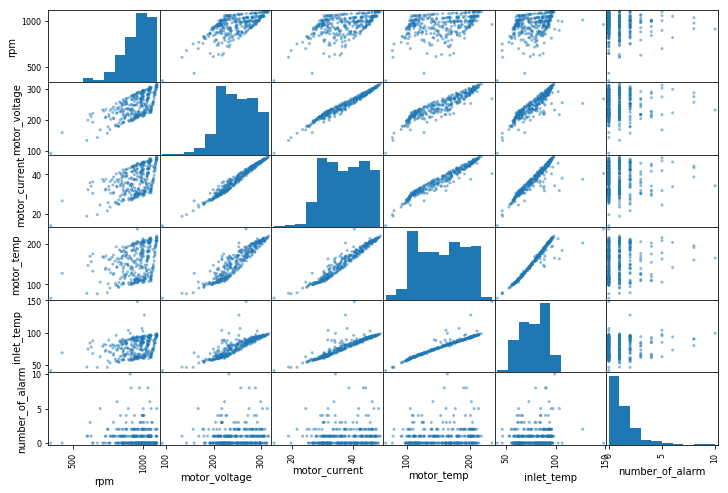

In [15]:
"""
In the next step, I want to read the data from a high level, try to find out whether some factors are 
closely connected with each other. If some factors are closely related to others, we can remove the 
the assoicated column to simplify the learning process.
"""
from pandas.plotting import scatter_matrix
attributes = ["rpm", "motor_voltage","motor_current" ,"motor_temp" , "inlet_temp", "number_of_alarm"]
scatter_matrix(rms_with_alarm[attributes], figsize = (12,8))

In [16]:
"""
Above figures show that motor voltage, current, motor temp, and inlet temp are closely correlated. 
In fact, when the conditons of motors become worse, in order to keep the rpm a contant number, the motor driver assign
higher voltage to overcome the resistance inside. Thus the current in the stator increase, more heat is generated.
"""
pass

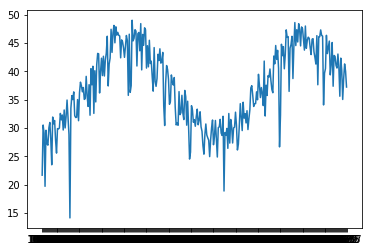

In [18]:
plt.plot(rms_with_alarm["motor_current"])
plt.show()

In [20]:
"""
Above fig shows the curve for the motor current. When the current reaches the peak for the first time, the motor continues
to work. But the motor fails when the current reaches the peak for the second time. Intuitively, though the motor works
well during the first peak period, its the insulation on the stator is damaged. Thus during the second peak period, the
motor is prone to fail.
"""
pass

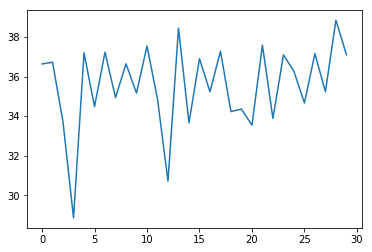

In [29]:
"""
Since the status of motors is closely related to current, I think it maybe easier to find out the motor in worst condition
by calculating the average current in the motor. It may be more accurate to take into considerion the other factors and 
assign each factor an weight optimized by mahcine learnning. 
But at this stage, I prefer to use this simplest method by comparing the average current in each unit. Calculation result
shows that number 0048 and 0033 are most likely to fail.
"""


current_list = []
for indi in range(20,50):
    filename_new = "data/test/unit00"+str(indi)+"_rms.csv"
    rms = load_rms(filename_new)
    rms_modify = abnormal_remove(rms)
    rms_date_modi = date_rename(rms_modify)
    rms_aver = average_tendays(rms_date_modi)
    
    temp = rms_aver["motor_current"]
    current_list.append(temp.mean())
    
xlabel = [x for x in range(20,50)]  
plt.plot(xlabel,current_list)
plt.show()


In [32]:
current_vec = np.array(current_list)
worst_unit = np.argmax(current_vec)+20
print(worst_unit)

"""
Thus, the unit that mostly likely to fail are unit 0048 and unit 0033
"""
pass

48
